# Bayesian Optimization of CNN with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up a simple CNN
- Set up the hyperparameter search shape
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [3]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [4]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

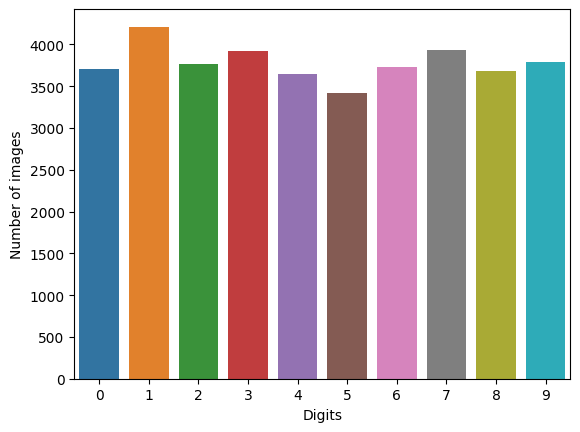

In [6]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [7]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [8]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [9]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [10]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

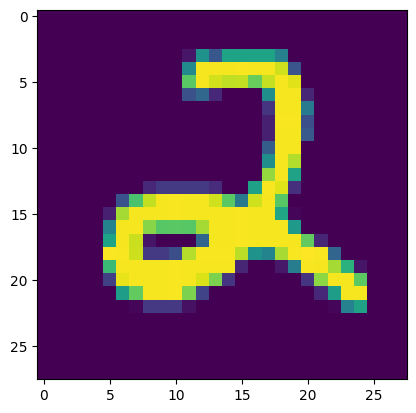

In [11]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

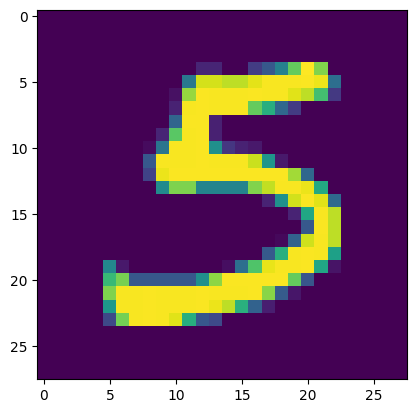

In [12]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers.

In fact, the number of fully-connected Dense layers and the number of Neurons in each one of the Dense layers, are some of the hyperparameters we want to optimize.

We could also optimize the number of Convolutional layers. But we will keep that for later, and here we keep it a bit simpler.

In [13]:
# function to create the CNN

def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function only.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [14]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [15]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

# Define the Objective Function

In [16]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [17]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [18]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = [1e-5, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 14s 52ms/step - loss: 2.2785 - accuracy: 0.1171 - val_loss: 2.2462 - val_accuracy: 0.1810 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 15s 55ms/step - loss: 2.1940 - accuracy: 0.2453 - val_loss: 2.1372 - val_accuracy: 0.2844 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 14s 51ms/step - loss: 2.0507 - accuracy: 0.2943 - val_loss: 1.9657 - val_accuracy: 0.3090 - lr: 1.0000e-05

Accuracy: 30.90%



-0.30899471044540405

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization

In [19]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 14s 53ms/step - loss: 2.2598 - accuracy: 0.2001 - val_loss: 2.2076 - val_accuracy: 0.2608 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 14s 53ms/step - loss: 2.1370 - accuracy: 0.2854 - val_loss: 2.0565 - val_accuracy: 0.3132 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 14s 53ms/step - loss: 1.9569 - accuracy: 0.3832 - val_loss: 1.8475 - val_accuracy: 0.4429 - lr: 1.0000e-05

Accuracy: 44.29%

learning rate: 2.4e-04
num_dense_layers: 4
num_dense_nodes: 440
activation: sigmoid

Epoch 1/3
266/266 [==============================] - 19s 68ms/step - loss: 2.3121 - accuracy: 0.1032 - val_loss: 2.3063 - val_accuracy: 0.1146 - lr: 2.3517e-04
Epoch 2/3
266/266 [==============================] - 17s 65ms/step - loss: 1.7545 - accuracy: 0.3765 - val_loss: 0.8707 - val_accuracy: 0.7320 - lr: 2.3517e-04
Epoch 3/3
266/2

C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 21s 76ms/step - loss: 2.2206 - accuracy: 0.1577 - val_loss: 1.3733 - val_accuracy: 0.4804 - lr: 7.6434e-04
Epoch 2/3
266/266 [==============================] - 20s 73ms/step - loss: 0.5789 - accuracy: 0.8079 - val_loss: 0.3067 - val_accuracy: 0.9040 - lr: 7.6434e-04
Epoch 3/3
266/266 [==============================] - 20s 76ms/step - loss: 0.2234 - accuracy: 0.9290 - val_loss: 0.1891 - val_accuracy: 0.9460 - lr: 7.6434e-04

Accuracy: 94.60%

learning rate: 1.9e-04
num_dense_layers: 5
num_dense_nodes: 381
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 19s 68ms/step - loss: 0.4953 - accuracy: 0.8531 - val_loss: 0.1856 - val_accuracy: 0.9439 - lr: 1.9302e-04
Epoch 2/3
266/266 [==============================] - 19s 71ms/step - loss: 0.1147 - accuracy: 0.9644 - val_loss: 0.0958 - val_accuracy: 0.9738 - lr: 1.9302e-04
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0781 - accuracy: 0.9758 - val_loss: 0.0766 - val_accuracy: 0.9780 - lr: 1.9302e-04

Accuracy: 97.80%

learning rate: 6.2e-04
num_dense_layers: 3
num_dense_nodes: 366
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 18s 67ms/step - loss: 0.3041 - accuracy: 0.9039 - val_loss: 0.1070 - val_accuracy: 0.9669 - lr: 6.1803e-04
Epoch 2/3
266/266 [==============================] - 17s 65ms/step - loss: 0.0697 - accuracy: 0.9785 - val_loss: 0.0613 - val_accuracy: 0.9802 - lr: 6.1803e-04
Epoch 3/3
266/266 [==============================] - 18s 66ms/step - loss: 0.0473 - accuracy: 0.9853 - val_loss: 0.0644 - val_accuracy: 0.9791 - lr: 6.1803e-04

Accuracy: 97.91%

learning rate: 9.1e-04
num_dense_layers: 4
num_dense_nodes: 379
activation: sigmoid

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 20s 72ms/step - loss: 2.2029 - accuracy: 0.1482 - val_loss: 1.3402 - val_accuracy: 0.5354 - lr: 9.1105e-04
Epoch 2/3
266/266 [==============================] - 22s 82ms/step - loss: 0.6781 - accuracy: 0.7670 - val_loss: 0.4125 - val_accuracy: 0.8640 - lr: 9.1105e-04
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.2927 - accuracy: 0.9078 - val_loss: 0.2381 - val_accuracy: 0.9288 - lr: 9.1105e-04

Accuracy: 92.88%

learning rate: 4.9e-04
num_dense_layers: 2
num_dense_nodes: 477
activation: sigmoid

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 19s 71ms/step - loss: 1.9331 - accuracy: 0.2979 - val_loss: 0.7079 - val_accuracy: 0.7852 - lr: 4.9316e-04
Epoch 2/3
266/266 [==============================] - 19s 72ms/step - loss: 0.4056 - accuracy: 0.8791 - val_loss: 0.3017 - val_accuracy: 0.9114 - lr: 4.9316e-04
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 0.2281 - accuracy: 0.9297 - val_loss: 0.2087 - val_accuracy: 0.9373 - lr: 4.9316e-04

Accuracy: 93.73%

learning rate: 5.4e-04
num_dense_layers: 5
num_dense_nodes: 512
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 21s 77ms/step - loss: 0.3348 - accuracy: 0.8897 - val_loss: 0.1279 - val_accuracy: 0.9635 - lr: 5.4305e-04
Epoch 2/3
266/266 [==============================] - 22s 81ms/step - loss: 0.0769 - accuracy: 0.9762 - val_loss: 0.0826 - val_accuracy: 0.9762 - lr: 5.4305e-04
Epoch 3/3
266/266 [==============================] - 21s 79ms/step - loss: 0.0480 - accuracy: 0.9851 - val_loss: 0.0614 - val_accuracy: 0.9828 - lr: 5.4305e-04

Accuracy: 98.28%

learning rate: 1.5e-03
num_dense_layers: 5
num_dense_nodes: 11
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 16s 58ms/step - loss: 1.2506 - accuracy: 0.5349 - val_loss: 0.6523 - val_accuracy: 0.7817 - lr: 0.0015
Epoch 2/3
266/266 [==============================] - 15s 58ms/step - loss: 0.4517 - accuracy: 0.8661 - val_loss: 0.3417 - val_accuracy: 0.9000 - lr: 0.0015
Epoch 3/3
266/266 [==============================] - 16s 59ms/step - loss: 0.2783 - accuracy: 0.9212 - val_loss: 0.2351 - val_accuracy: 0.9357 - lr: 0.0015

Accuracy: 93.57%

learning rate: 2.4e-03
num_dense_layers: 1
num_dense_nodes: 5
activation: sigmoid

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 16s 58ms/step - loss: 2.3030 - accuracy: 0.1087 - val_loss: 2.3011 - val_accuracy: 0.1146 - lr: 0.0024
Epoch 2/3
266/266 [==============================] - 17s 65ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3011 - val_accuracy: 0.1146 - lr: 0.0024
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3015 - accuracy: 0.1111
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0011805467074736953.
266/266 [==============================] - 16s 62ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3012 - val_accuracy: 0.1146 - lr: 0.0024

Accuracy: 11.46%

learning rate: 3.3e-03
num_dense_layers: 5
num_dense_nodes: 512
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 21s 78ms/step - loss: 0.3059 - accuracy: 0.8989 - val_loss: 0.1085 - val_accuracy: 0.9730 - lr: 0.0033
Epoch 2/3
266/266 [==============================] - 21s 78ms/step - loss: 0.0871 - accuracy: 0.9787 - val_loss: 0.1033 - val_accuracy: 0.9802 - lr: 0.0033
Epoch 3/3
266/266 [==============================] - 21s 80ms/step - loss: 0.0593 - accuracy: 0.9859 - val_loss: 0.0910 - val_accuracy: 0.9823 - lr: 0.0033

Accuracy: 98.23%

learning rate: 4.6e-03
num_dense_layers: 4
num_dense_nodes: 190
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 63ms/step - loss: 0.2333 - accuracy: 0.9249 - val_loss: 0.0762 - val_accuracy: 0.9767 - lr: 0.0046
Epoch 2/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0710 - accuracy: 0.9796 - val_loss: 0.0579 - val_accuracy: 0.9831 - lr: 0.0046
Epoch 3/3
266/266 [==============================] - 17s 62ms/step - loss: 0.0478 - accuracy: 0.9868 - val_loss: 0.0493 - val_accuracy: 0.9865 - lr: 0.0046

Accuracy: 98.65%

learning rate: 3.7e-03
num_dense_layers: 1
num_dense_nodes: 294
activation: sigmoid

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 64ms/step - loss: 1.9814 - accuracy: 0.2818 - val_loss: 0.5702 - val_accuracy: 0.8098 - lr: 0.0037
Epoch 2/3
266/266 [==============================] - 17s 64ms/step - loss: 0.2483 - accuracy: 0.9248 - val_loss: 0.1575 - val_accuracy: 0.9558 - lr: 0.0037
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.1191 - accuracy: 0.9626 - val_loss: 0.1109 - val_accuracy: 0.9653 - lr: 0.0037

Accuracy: 96.53%

learning rate: 1.0e-02
num_dense_layers: 5
num_dense_nodes: 362
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 18s 65ms/step - loss: 2.3375 - accuracy: 0.1073 - val_loss: 2.3015 - val_accuracy: 0.1146 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 18s 67ms/step - loss: 2.3020 - accuracy: 0.1111 - val_loss: 2.3009 - val_accuracy: 0.1146 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3019 - accuracy: 0.1098
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
266/266 [==============================] - 18s 68ms/step - loss: 2.3019 - accuracy: 0.1098 - val_loss: 2.3018 - val_accuracy: 0.1037 - lr: 0.0100

Accuracy: 10.37%

learning rate: 2.1e-03
num_dense_layers: 3
num_dense_nodes: 134
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 60ms/step - loss: 0.2396 - accuracy: 0.9235 - val_loss: 0.1010 - val_accuracy: 0.9725 - lr: 0.0021
Epoch 2/3
266/266 [==============================] - 16s 58ms/step - loss: 0.0623 - accuracy: 0.9803 - val_loss: 0.0632 - val_accuracy: 0.9823 - lr: 0.0021
Epoch 3/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0414 - accuracy: 0.9871 - val_loss: 0.0511 - val_accuracy: 0.9865 - lr: 0.0021

Accuracy: 98.65%

learning rate: 3.2e-04
num_dense_layers: 1
num_dense_nodes: 263
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 61ms/step - loss: 0.4704 - accuracy: 0.8708 - val_loss: 0.1626 - val_accuracy: 0.9566 - lr: 3.2429e-04
Epoch 2/3
266/266 [==============================] - 16s 61ms/step - loss: 0.1162 - accuracy: 0.9648 - val_loss: 0.1112 - val_accuracy: 0.9669 - lr: 3.2429e-04
Epoch 3/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.0820 - val_accuracy: 0.9749 - lr: 3.2429e-04

Accuracy: 97.49%

learning rate: 1.0e-02
num_dense_layers: 4
num_dense_nodes: 82
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 62ms/step - loss: 0.3117 - accuracy: 0.8958 - val_loss: 0.1073 - val_accuracy: 0.9714 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 17s 64ms/step - loss: 0.0801 - accuracy: 0.9785 - val_loss: 0.0942 - val_accuracy: 0.9810 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 14s 53ms/step - loss: 0.0730 - accuracy: 0.9816 - val_loss: 0.0879 - val_accuracy: 0.9802 - lr: 0.0100

Accuracy: 98.02%

learning rate: 1.0e-06
num_dense_layers: 5
num_dense_nodes: 328
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 62ms/step - loss: 2.2982 - accuracy: 0.1404 - val_loss: 2.2908 - val_accuracy: 0.2643 - lr: 1.0000e-06
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 2.2817 - accuracy: 0.3885 - val_loss: 2.2726 - val_accuracy: 0.4444 - lr: 1.0000e-06
Epoch 3/3
266/266 [==============================] - 17s 63ms/step - loss: 2.2600 - accuracy: 0.4803 - val_loss: 2.2470 - val_accuracy: 0.5003 - lr: 1.0000e-06

Accuracy: 50.03%

learning rate: 1.5e-03
num_dense_layers: 3
num_dense_nodes: 512
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 17s 62ms/step - loss: 0.2126 - accuracy: 0.9306 - val_loss: 0.0813 - val_accuracy: 0.9749 - lr: 0.0015
Epoch 2/3
266/266 [==============================] - 17s 62ms/step - loss: 0.0588 - accuracy: 0.9813 - val_loss: 0.0803 - val_accuracy: 0.9775 - lr: 0.0015
Epoch 3/3
266/266 [==============================] - 16s 61ms/step - loss: 0.0412 - accuracy: 0.9872 - val_loss: 0.0475 - val_accuracy: 0.9860 - lr: 0.0015

Accuracy: 98.60%

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 491
activation: sigmoid

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 16s 59ms/step - loss: 2.4689 - accuracy: 0.1008 - val_loss: 2.3422 - val_accuracy: 0.0960 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 2.3854 - accuracy: 0.0987 - val_loss: 2.4680 - val_accuracy: 0.0960 - lr: 0.0100
Epoch 3/3
265/266 [============================>.] - ETA: 0s - loss: 2.3934 - accuracy: 0.1004
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
266/266 [==============================] - 16s 59ms/step - loss: 2.3934 - accuracy: 0.1005 - val_loss: 2.4428 - val_accuracy: 0.0937 - lr: 0.0100

Accuracy: 9.37%

learning rate: 6.1e-05
num_dense_layers: 2
num_dense_nodes: 512
activation: relu

Epoch 1/3


C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 18s 66ms/step - loss: 0.9004 - accuracy: 0.7762 - val_loss: 0.3226 - val_accuracy: 0.9026 - lr: 6.0790e-05
Epoch 2/3
266/266 [==============================] - 18s 69ms/step - loss: 0.2434 - accuracy: 0.9283 - val_loss: 0.2191 - val_accuracy: 0.9381 - lr: 6.0790e-05
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.1708 - accuracy: 0.9491 - val_loss: 0.1654 - val_accuracy: 0.9526 - lr: 6.0790e-05

Accuracy: 95.26%



# Analyze results

In [21]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9865'

In [22]:
gp_.x

[0.004619052333662549, 4, 190, 'relu']

In [23]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=5, high=512, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [24]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- learning rate=0.004619
- num_dense_layers=4
- num_nodes=190
- activation = relu


## Convergence

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

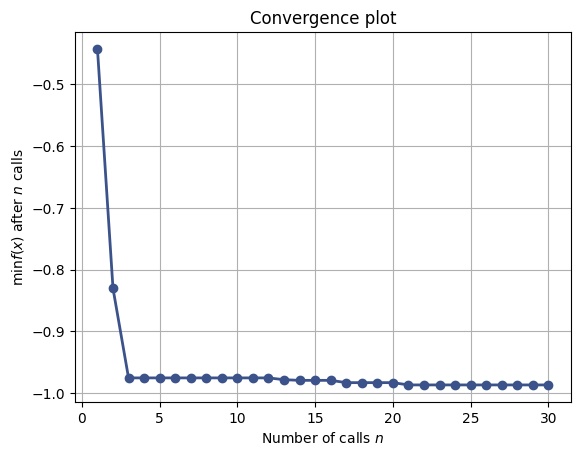

In [25]:
plot_convergence(gp_)

## Partially dependency plots

[plot_objective](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective)

In [26]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

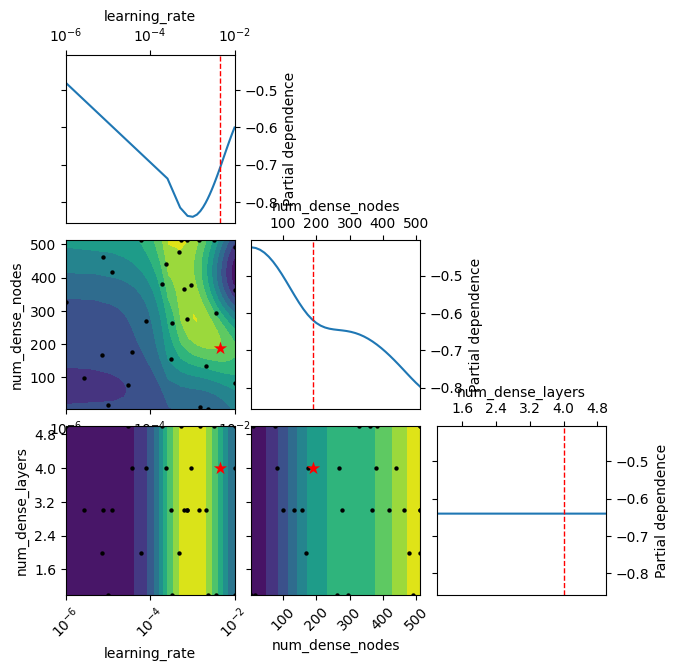

In [27]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

## Evaluation order

[plot_evaluations](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html)

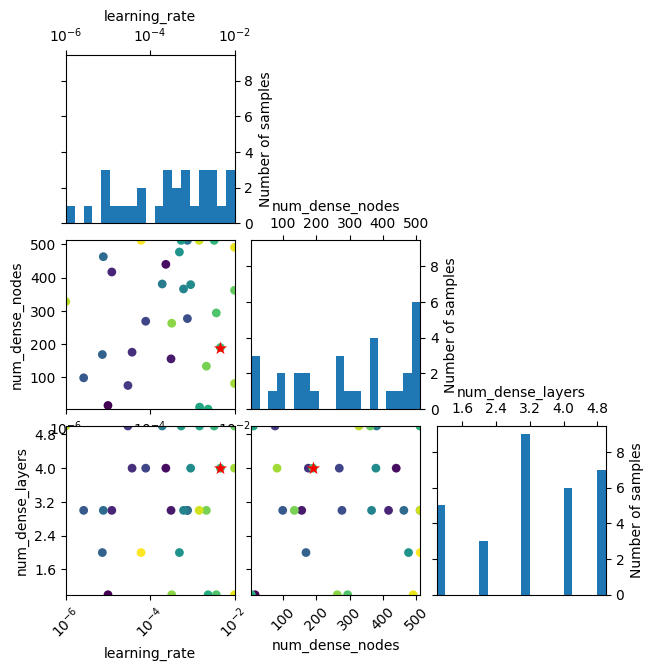

In [28]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

# Evaluate the model

In [29]:
# load best model

model = load_model(path_best_model)

In [30]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 4ms/step - loss: 0.0610 - accuracy: 0.9860


In [31]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.061048757284879684
accuracy 0.9859523773193359


## Confusion matrix

In [32]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 1s 4ms/step


array([[420,   0,   0,   0,   1,   0,   0,   0,   1,   0],
       [  0, 468,   2,   0,   0,   0,   0,   2,   1,   0],
       [  1,   0, 406,   0,   0,   0,   0,   1,   1,   0],
       [  1,   0,   3, 418,   0,   3,   0,   1,   0,   0],
       [  0,   2,   0,   0, 426,   0,   0,   0,   0,   1],
       [  0,   0,   0,   1,   0, 378,   2,   0,   0,   1],
       [  1,   0,   1,   0,   5,   1, 402,   0,   1,   1],
       [  0,   1,   6,   0,   1,   1,   0, 459,   0,   1],
       [  1,   1,   0,   0,   1,   2,   0,   0, 379,   0],
       [  2,   0,   0,   0,   3,   0,   0,   0,   4, 385]], dtype=int64)

Text(0.5, 21.34715460257995, 'Predicted label')

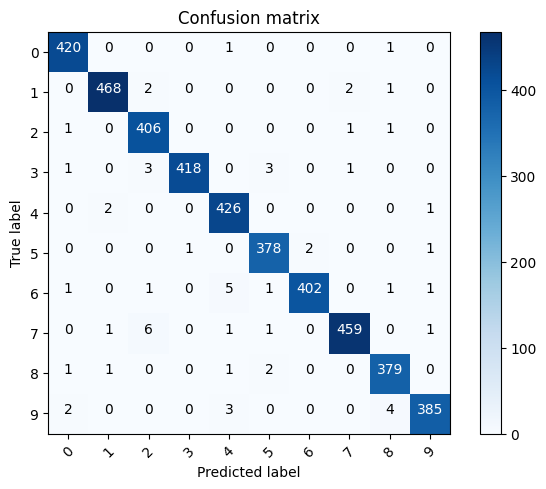

In [33]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

#  References

This notebook was based on these resources:

- [TensorFlow Tutorial #19](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb)
- [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
- [Keras](https://keras.io/)